# Accurately predicting human essential genes based on deep learning

This section will present a comparative analysis to demonstrate the application and performance of PyTorch models for addressing sequence-based prediction problems.

We'll try to replicate the [Deep Learning in Genomics Primer Notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) which is a supplement to the manuscript [A Primer on Deep Learning in Genomics](https://www.nature.com/articles/s41588-018-0295-5). We've already successfully replicated it before using Machine Learning models and Keras. So, the main focus of this notebook is to also demonstrate the application of ProPythia to the identification of DNA-binding motifs using DNA descriptors, but using a deep learning model this time.

In [37]:
%load_ext autoreload
import pandas as pd
import sys
import os
import torch
from torch import nn
from torch.optim import Adam
sys.path.append("../")
from descriptors.descriptors import DNADescriptor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
dataset = pd.read_csv("datasets/primer/dataset.csv")
print(dataset.shape)
print(dataset.head())

(2000, 2)
                                            sequence  label
0  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...      0
1  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...      0
2  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...      0
3  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...      1
4  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...      1


As we can see, this dataset contains the sequence and the corresponding positive/negative class labels, with positive class labels corresponding to the presence of a DNA-binding motif. The amount of positive and negative examples is evenly distributed across the two classes.

<AxesSubplot:xlabel='label'>

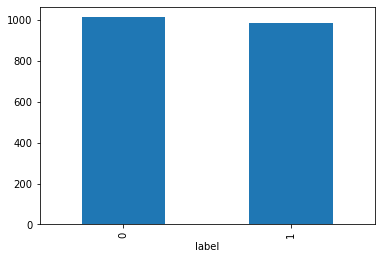

In [39]:
dataset.groupby('label').size().plot(kind='bar')

To calculate features, and to be more easy, we create a function to calculate features, calculating all available DNA features.
There are a total of 17 DNA descriptors. They are: 
- length
- gc_content
- at_content
- nucleic_acid_composition
- dinucleotide_composition
- trinucleotide_composition
- k_spaced_nucleic_acid_pairs
- kmer
- accumulated_nucleotide_frequency
- DAC
- DCC
- DACC
- TAC
- TCC
- TACC
- PseDNC
- PseKNC

In [40]:
def calculate_feature(data):
    list_feature = []
    count = 0
    for seq in data['sequence']:
        res = {'sequence': seq}
        dna = DNADescriptor(seq)
        feature = dna.get_descriptors()
        res.update(feature)
        list_feature.append(res)
        
        # print progress every 100 sequences
        if count % 100 == 0:
            print(count, '/', len(data))

        count += 1
    print("Done!")
    df = pd.DataFrame(list_feature)
    return df

features = calculate_feature(dataset)

0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000
Done!


In [41]:
fps_y = dataset['label']
fps_x = features.loc[:, features.columns != 'label']
fps_x = fps_x.loc[:, fps_x.columns != 'sequence']
fps_x.shape

(2000, 17)

Now, we have a dataset (fps_x) with 17 columns. Each column is a result of a DNA descriptor, and some of these columns are numbers, dicts and even lists.

Even though we've computed all of the descriptors, we still need to normalize those who have dictionaries and lists because the model can't handle data in these types.

To normalize the data, dicts and lists need to "explode" into more columns. 

E.g. dicts:

| descriptor_hello |
| ---------------- |
| {'a': 1, 'b': 2} |

will be transformed into:

| descriptor_hello_a | descriptor_hello_b |
| ------------------ | ------------------ |
| 1                  | 2                  |

E.g. lists:

| descriptor_hello |
| ---------------- |
| [1, 2, 3]        |

will be transformed into:

| descriptor_hello_0 | descriptor_hello_1 | descriptor_hello_2 |
| ------------------ | ------------------ | ------------------ |
| 1                  | 2                  | 3                  |

In [42]:
def process_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    fps_x.drop(field, axis=1, inplace=True)
    return new_df

def process_lists_of_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    empty_val = {} if field == "enhanced_nucleic_acid_composition" else []
    small_processed = []
    for f in new_df.columns:
        col = [empty_val if i is None else i for i in new_df[f].to_list()]
        sub = pd.DataFrame(col)
        sub.columns = [str(f) + "_" + str(i) for i in sub.columns]
        small_processed.append(sub)
    fps_x.drop(field, axis=1, inplace=True)
    return small_processed

In [43]:
no_need_normalization = ["length", "at_content", "gc_content"]
lists = ["nucleic_acid_composition","dinucleotide_composition","trinucleotide_composition","k_spaced_nucleic_acid_pairs","kmer","PseDNC", "PseKNC", "DAC", "DCC", "DACC", "TAC","TCC","TACC"]
lists_of_lists = [
    "accumulated_nucleotide_frequency"
]

small_processed = []
for i in lists:
    new_df = process_lists(fps_x, i)
    small_processed.append(new_df)
    
for i in lists_of_lists:
    smaller_processed = process_lists_of_lists(fps_x, i)
    small_processed += smaller_processed

# concat final with original
fps_x = pd.concat([fps_x, *small_processed], axis=1)
fps_x

,length,gc_content,at_content,nucleic_acid_composition_A,nucleic_acid_composition_C,nucleic_acid_composition_G,nucleic_acid_composition_T,dinucleotide_composition_AA,dinucleotide_composition_AC,dinucleotide_composition_AG,...,accumulated_nucleotide_frequency_0_G,accumulated_nucleotide_frequency_0_T,accumulated_nucleotide_frequency_1_A,accumulated_nucleotide_frequency_1_C,accumulated_nucleotide_frequency_1_G,accumulated_nucleotide_frequency_1_T,accumulated_nucleotide_frequency_2_A,accumulated_nucleotide_frequency_2_C,accumulated_nucleotide_frequency_2_G,accumulated_nucleotide_frequency_2_T
0,50,0.60,0.40,0.18,0.26,0.34,0.22,0.041,0.061,0.061,...,0.462,0.154,0.20,0.12,0.40,0.28,0.184,0.184,0.368,0.263
1,50,0.48,0.52,0.12,0.16,0.32,0.40,0.000,0.020,0.061,...,0.308,0.385,0.20,0.16,0.36,0.28,0.158,0.132,0.316,0.395
2,50,0.54,0.46,0.34,0.26,0.28,0.12,0.082,0.061,0.163,...,0.385,0.154,0.44,0.12,0.36,0.08,0.368,0.263,0.263,0.105
3,50,0.64,0.36,0.24,0.42,0.22,0.12,0.020,0.143,0.082,...,0.231,0.077,0.24,0.44,0.16,0.16,0.237,0.421,0.211,0.132
4,50,0.54,0.46,0.28,0.26,0.28,0.18,0.082,0.102,0.041,...,0.308,0.077,0.32,0.36,0.20,0.12,0.289,0.342,0.211,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,50,0.66,0.34,0.16,0.26,0.40,0.18,0.000,0.020,0.082,...,0.538,0.154,0.12,0.20,0.52,0.16,0.184,0.211,0.421,0.184
1996,50,0.44,0.56,0.22,0.22,0.22,0.34,0.041,0.061,0.041,...,0.308,0.308,0.20,0.12,0.28,0.40,0.237,0.211,0.263,0.289
1997,50,0.46,0.54,0.18,0.24,0.22,0.36,0.020,0.061,0.041,...,0.154,0.231,0.16,0.36,0.16,0.32,0.132,0.263,0.211,0.395
1998,50,0.48,0.52,0.28,0.24,0.24,0.24,0.102,0.061,0.041,...,0.462,0.077,0.24,0.32,0.28,0.16,0.237,0.289,0.289,0.184


In [44]:
%load_ext autoreload
%autoreload 2
from src.models import MLP
from src.train import traindata
from src.test import test
from src.prepare_data import prepare_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
torch.manual_seed(2022)
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

paramDict = {
    'epochs': 50,
    'batch_size': 32,
    'dropout': 0.2,
    'loss': nn.CrossEntropyLoss(),
    'input_size': fps_x.shape[1],
    'hidden_size': 128,
    'output_size': 2,
    'patience': 2,
    'lr': 0.001
}

model = MLP(
    paramDict['input_size'],
    paramDict['hidden_size'],
    paramDict['output_size'],
    paramDict['dropout']
).to(device)

optimizer = Adam(model.parameters(), lr=paramDict['lr'])

trainloader, testloader, validloader = prepare_data(
    fps_x, fps_y, 
    mode='descriptors',
    batch_size=paramDict['batch_size'],
)

model = traindata(device, model, paramDict['epochs'], optimizer, paramDict['loss'], trainloader, validloader, paramDict['patience'])

# Test
acc, mcc, report = test(device, model, testloader)
print('Accuracy: %.3f' % acc)
print('MCC: %.3f' % mcc)
print(report)

x_train.shape: (1200, 247)
y_train.shape: (1200,)
x_test.shape: (400, 247)
y_test.shape: (400,)
x_cv.shape: (400, 247)
y_cv.shape: (400,)
[1/50, 0/38] loss: 0.68806624
The Current Loss: 0.3629840543636909
trigger times: 0
[2/50, 0/38] loss: 0.34050795
The Current Loss: 0.3482062381047469
trigger times: 0
[3/50, 0/38] loss: 0.35572395
The Current Loss: 0.37050804725060094
Trigger Times: 1
[4/50, 0/38] loss: 0.31344163
The Current Loss: 0.3427925728834592
trigger times: 0
[5/50, 0/38] loss: 0.31341898
The Current Loss: 0.3413308262825012
trigger times: 0
[6/50, 0/38] loss: 0.3133167
The Current Loss: 0.34699147939682007
Trigger Times: 1
[7/50, 0/38] loss: 0.34452176
The Current Loss: 0.345127862233382
trigger times: 0
[8/50, 0/38] loss: 0.4070113
The Current Loss: 0.33939619018481326
trigger times: 0
[9/50, 0/38] loss: 0.3133252
The Current Loss: 0.34233559324191165
Trigger Times: 1
[10/50, 0/38] loss: 0.31326506
The Current Loss: 0.3489302419699155
Trigger Times: 2
Early stopping!
Start